# FISHER FOR PROBIT

We first create a monte carlo simulation to compute an approximation of the cumulative standard normal distribution. The function returns two arrays, one containing the values taken by the cdf function (y_values) and the other containing the corresponding x values (x_values). These two arrays constitute a discrete approximation of the normal cdf .  
  
Next, we define another function "normalCDF()", which takes a vector or scalar as its main argument and computes the correponding cdf value for each element (if it's a vector), interpolating using our previously defined arrays and np.interp.

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from tabulate import tabulate

In [3]:
def monte_carlo_cdf_estimation(num_samples=100000000):
    # Generate random samples from standard normal distribution
    random_samples = np.random.randn(num_samples)

    # Sort the samples
    x_values = np.sort(random_samples)

    # Calculate the cumulative probabilities
    y_values = np.arange(1, num_samples + 1) / num_samples

    return y_values , x_values

y_values, x_values = monte_carlo_cdf_estimation()

In [4]:
def normalCDF(vec,cdf_values = y_values, sorted_samples = x_values):
    if isinstance(vec,(np.ndarray,list)):
        
        res = []
        for x in vec:

            res.append(np.interp(x, sorted_samples, cdf_values))

    elif isinstance(vec,(int,float)):

        res = np.interp(vec, sorted_samples, cdf_values)
        
        return res
    
    else:
        raise TypeError("Type not supported")

    return np.array(res)

We define a function to calculate the value of a standard normal probability density function of a number x

In [5]:
#Function to calculate the value of a standard normal
def standardNormalPdf(x):
    return (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * (x ** 2))

Finally, we define our Fisher Scoring algorithm which employs the afore mentioned functions

In [6]:
#Probit function
def probit_glm(X, Y, epsilon = 1e-6, fit_intercept = True):
    n, p = np.shape(X)
    #In case there's no column for the intercept (fit_intercept = True) add it
    if fit_intercept:
        ones = np.ones(n,dtype = "float64").reshape(n,1)
        Z = np.hstack((ones,X))
        X = Z
        n, p = np.shape(X)
        
    #list containing the marginal updates for later diagnostics
    dN = []
    
    # Initial values of the algorithm
    b_0 = np.zeros((p, 1))
    eta = np.dot(X,b_0) 
    mu = normalCDF(eta) #calculate mu using the cumulative normal distribution defined above
    var = mu * (1 - mu) + epsilon #variance of Y 
    w = (1/var) * standardNormalPdf(eta) ** 2 
    W = np.diag(w.reshape(n,)) #Weight matrix
    Z = eta + (Y - mu) * (standardNormalPdf(eta) ** -1) # Z matrix
 
    #Loop until convergence is reached (convergence = True)
    convergence = False
    iteration = 1
    start = time.time()
    while convergence == False:

        # Compute new estimate by solving the linear system XtWXb - XtWZ = 0 so we don't need to invert the matrix
        XtWX = np.linalg.multi_dot([X.T,W,X])
        XtWZ = np.linalg.multi_dot([X.T,W,Z])
        b = np.linalg.solve(XtWX,XtWZ)

        #Compute new values of the parameters
        eta = np.dot(X,b) 
        mu = normalCDF(eta) 
        var = mu * (1 - mu) + epsilon
        w = (1/var) * standardNormalPdf(eta) ** 2
        W = np.diag(w.reshape(n,))
        Z = eta + (Y - mu) * (standardNormalPdf(eta) ** -1)

        dN.append(np.linalg.norm(b-b_0)/(np.linalg.norm(b_0)+epsilon))

        # Check for convergence
        if np.linalg.norm(b-b_0)/(np.linalg.norm(b_0)+epsilon) < epsilon:
            convergence = True
            end = time.time()
            #printing report
            print("\nConvergence reached with value:",np.linalg.norm(b-b_0)/(np.linalg.norm(b_0)+epsilon))
            t = end - start
            print(f"Time: {t: .2f} seconds" if t < 60 else f"Time: {(t//60):.0f} minutes{t % 60: .1f} seconds")
            print("Number of iterations:", iteration)
            print(f"Estimated coefficients: {[f'Beta_{x}: {b[x][0] : .3f}' for x in range(len(b))]}")

        #update old value and increment iteration
        b_0 = b 
        iteration += 1

    #getting standard errors
    cov = np.linalg.inv(XtWX)
    se = np.sqrt(np.diag(cov))
    
    return b,dN,se,iteration

Testing the algorithm on simulated data

In [7]:
p=4
n=1000
epsilon = 1e-6
np.random.seed(42)

X = np.ones(n, dtype=int)
X = np.reshape(X, (n, 1))
X = np.hstack((X, np.random.normal(size=(n, p)))) 

true_beta = np.random.randint(3, size=p+1) 
pred = norm.cdf(np.dot(X, true_beta))
Y = np.random.binomial(1,pred).reshape((n,1))


beta , deltaNorm, se ,iter= probit_glm(X,Y,epsilon =epsilon,fit_intercept = False)


Convergence reached with value: 4.1441436799464557e-08
Time:  0.91 seconds
Number of iterations: 9
Estimated coefficients: ['Beta_0:  2.022', 'Beta_1:  0.999', 'Beta_2:  0.002', 'Beta_3:  1.060', 'Beta_4: -0.023']


Running some diagnostics in order to see the parameter evolution.

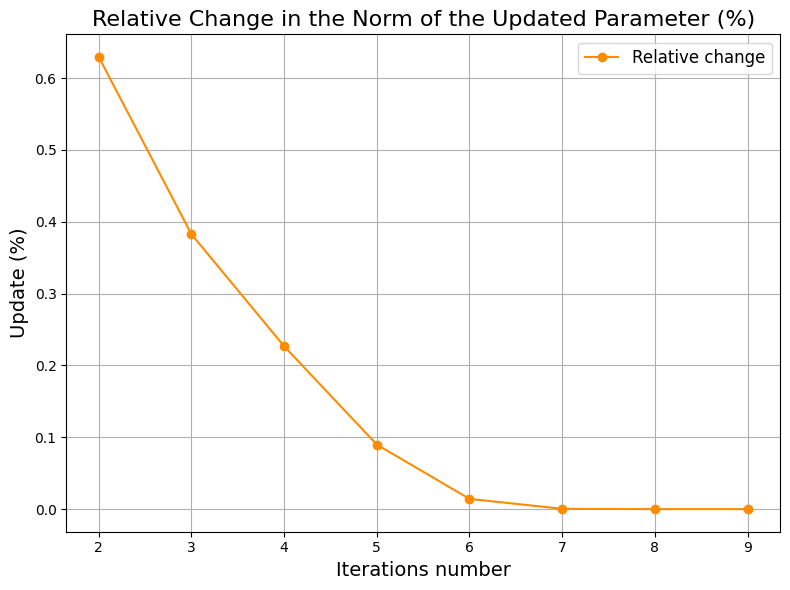

In [192]:
iterations = list(range(1, iter))


plt.figure(figsize=(8, 6))

plt.plot(iterations[1:], deltaNorm[1:], marker='o', linestyle='-', color='darkorange', label='Relative change')

plt.title('Relative Change in the Norm of the Updated Parameter (%)', fontsize=16)
plt.xlabel('Iteration number', fontsize=14)
plt.ylabel('Update (%)', fontsize=14)
plt.legend(loc='best', fontsize=12)  
plt.grid(True)

plt.tight_layout()
plt.show()


### *RUNNING THE ALGORITHM ON THE SAHEART DATASET*

#### Simple data cleaning

In [9]:
df = pd.read_csv("SAheart.txt",sep=" ")

In [10]:
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB


In [12]:
#encoding the famhist variable to 0
df.famhist = df.famhist.replace("Present",1)
df.famhist = df.famhist.replace("Absent",0)
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [13]:
#Changing all variable types in the dataset to be float
for col in df.columns:
    df[col] = df[col].astype("float64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    float64
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    float64
 5   typea      462 non-null    float64
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    float64
 9   chd        462 non-null    float64
dtypes: float64(10)
memory usage: 36.2 KB


#### Running the model

In [14]:
X = np.array(df.drop("chd",axis = 1).copy())
Y = np.array(df["chd"]).reshape(-1,1)

In [15]:
beta, deltaNorm, se, iter  = probit_glm(X,Y)


Convergence reached with value: 7.134058968013176e-08
Time:  0.35 seconds
Number of iterations: 7
Estimated coefficients: ['Beta_0: -3.570', 'Beta_1:  0.004', 'Beta_2:  0.048', 'Beta_3:  0.103', 'Beta_4:  0.012', 'Beta_5:  0.539', 'Beta_6:  0.024', 'Beta_7: -0.040', 'Beta_8:  0.000', 'Beta_9:  0.026']


### *SUMMARIZING THE RESULTS*

In [16]:
def summarize(estimates,standard_errors):
    #calculating p values, z statistic and 95% CI
    estimates = estimates.flatten()
    z = estimates/standard_errors
    p_values = [round(2 * (1 - normalCDF(abs(est) / std_err)),3) for est, std_err in zip(estimates, standard_errors)]
    me = se * 1.96
    lower = estimates - me
    upper = estimates + me
    #Labels for the coefficients
    labels = [f"Beta_{x}" if x > 0 else "const" for x in range(len(estimates))]
    names = list(df.drop("chd",axis=1).columns)
    names.insert(0,"")
    
    #tabulate the results and print them
    table_data = list(zip(labels, names, estimates, z, standard_errors, p_values, lower, upper))
    headers = ['','','Coefficients',"Z", 'Standard Errors', 'P-Values',"[0.025","0.975]"]
    print("Probit estimation:\n")
    print(tabulate(table_data, headers=headers, floatfmt=".3f"))


summarize(beta,se)

Probit estimation:

                     Coefficients       Z    Standard Errors    P-Values    [0.025    0.975]
------  ---------  --------------  ------  -----------------  ----------  --------  --------
const                      -3.570  -4.749              0.752       0.000    -5.044    -2.097
Beta_1  sbp                 0.004   1.105              0.003       0.269    -0.003     0.011
Beta_2  tobacco             0.048   3.044              0.016       0.002     0.017     0.079
Beta_3  ldl                 0.103   2.914              0.035       0.004     0.034     0.172
Beta_4  adiposity           0.012   0.713              0.017       0.476    -0.022     0.046
Beta_5  famhist             0.539   3.998              0.135       0.000     0.275     0.803
Beta_6  typea               0.024   3.277              0.007       0.001     0.009     0.038
Beta_7  obesity            -0.040  -1.528              0.026       0.127    -0.092     0.011
Beta_8  alcohol             0.000   0.007         

#### Diagnostics

We remove the first iteration because we start from a parameter vector of zeros with norm zero, and since the update is relative to the previous value, dividing by $0 + \epsilon$ will give us a very large update.

Without the first iteration:

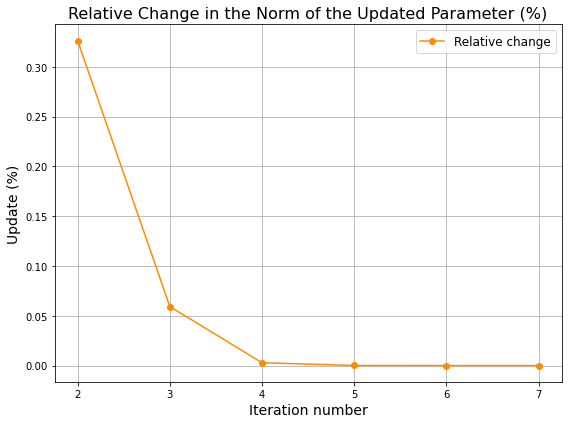

In [17]:
iterations = list(range(1, iter))


plt.figure(figsize=(8, 6))

plt.plot(iterations[1:], deltaNorm[1:], marker='o', linestyle='-', color='darkorange', label='Relative change')

plt.title('Relative Change in the Norm of the Updated Parameter (%)', fontsize=16)
plt.xlabel('Iteration number', fontsize=14)
plt.ylabel('Update (%)', fontsize=14)
plt.legend(loc='best', fontsize=12)  
plt.grid(True)

plt.tight_layout()
plt.show()

With the first iteration:

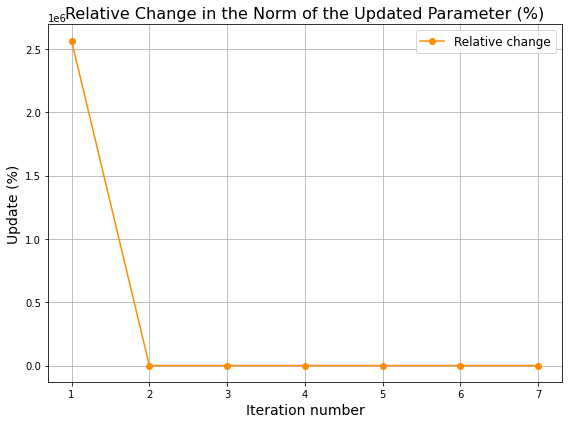

In [18]:
iterations = list(range(1, iter))


plt.figure(figsize=(8, 6))

plt.plot(iterations, deltaNorm, marker='o', linestyle='-', color='darkorange', label='Relative change')

plt.title('Relative Change in the Norm of the Updated Parameter (%)', fontsize=16)
plt.xlabel('Iteration number', fontsize=14)
plt.ylabel('Update (%)', fontsize=14)
plt.legend(loc='best', fontsize=12)  
plt.grid(True)

plt.tight_layout()
plt.show()

### *CHECKING CONSISTENCY WITH EXTERNAL LIBRARIES*

In [19]:
import statsmodels.api as sm

#by default the stats model package does not include the intercept, so we include it here
X_const = sm.add_constant(X)

probit_model = sm.Probit(Y, X_const).fit()

print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.510740
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                  462
Model:                         Probit   Df Residuals:                      452
Method:                           MLE   Df Model:                            9
Date:                Tue, 09 Jan 2024   Pseudo R-squ.:                  0.2083
Time:                        21:27:35   Log-Likelihood:                -235.96
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 1.856e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5702      0.749     -4.767      0.000      -5.038      -2.102
x1             0.0038      0.

## MCMC FOR BAYESIAN PROBIT REGRESSION

In [76]:
def gibbs_sampler(X, y, burn_in = 200, N_sim = 1000, fit_intercept = True):

    """ Gibbs sampling algorithm """
    
    n, D = np.shape(X)
    #In case there's no column for the intercept (fit_intercept = True) add it
    if fit_intercept:
        ones = np.ones(n,dtype = "float64").reshape(n,1)
        Z = np.hstack((ones,X))
        X = Z
        n, D = np.shape(X)
    

    # Conjugate prior on the coefficients beta ~ N(beta_0, Q_0)
    beta_0 = np.zeros(D)
    Q_0 = np.diag([10] * D)

    # Initialize parameters
    beta = np.zeros(D)
    z = np.zeros(n)

    # Variables that we will need later
    N1 = np.sum(y)  # Number of successes
    N0 = n - N1  # Number of failures

    # Matrix storing samples of the beta parameter
    beta_chain = np.zeros((N_sim, D))   

    # Compute posterior variance of beta
    prec_0 = np.linalg.inv(Q_0)
    V = np.linalg.inv(prec_0 + np.dot(X.T, X))

    for t in range(1, N_sim):
        # Update Mean of z
        mu_z = np.dot(X, beta)
        # Draw latent variable z from its full conditional: z | beta, y, X
        for i in range(n):
            if y[i] == 0:
                a = -np.inf
                b = 0
            else:
                a = 0
                b = np.inf
            a, b = (a - mu_z[i]) / 1, (b - mu_z[i]) / 1  # scale for std normal
            z[i] = mu_z[i] + norm.ppf(np.random.uniform(normalCDF(a), normalCDF(b))) * 1
    
        # Compute posterior mean of beta
        M = np.dot(V, np.dot(prec_0, beta_0) + np.dot(X.T, z))
        # Draw variable beta from its full conditional: beta | z, X
        beta = np.random.multivariate_normal(M, V)
    
        # Store the beta draws
        beta_chain[t, :] = beta

    # Discard the 'burn-in' iterations
    return beta_chain[burn_in:, :]

Running the model:

In [77]:
beta_chain = gibbs_sampler(X, Y)      # might take some minutes to run!

### *SUMMARIZING THE RESULTS*

In [78]:
def summarize(chain):
    #calculating mean and 95% Credible Interval
    estimates = np.mean(beta_chain, axis=0)
    lower = np.percentile(beta_chain, [2.5, 97.5], axis=0)[0]
    upper = np.percentile(beta_chain, [2.5, 97.5], axis=0)[1]
    
    #Labels for the coefficients
    labels = [f"Beta_{x}" if x > 0 else "const" for x in range(len(estimates))]
    names = list(df.drop("chd",axis=1).columns)
    names.insert(0,"")
    
    #tabulate the results and print them
    table_data = list(zip(labels, names, estimates, lower, upper))
    headers = ['','','Coefficients',"[0.025","0.975]"]
    print("Bayesian Probit estimation:\n")
    print(tabulate(table_data, headers=headers, floatfmt=".3f"))

summarize(beta_chain)

Bayesian Probit estimation:

                     Coefficients    [0.025    0.975]
------  ---------  --------------  --------  --------
const                      -3.303    -4.552    -1.972
Beta_1  sbp                 0.003    -0.003     0.010
Beta_2  tobacco             0.049     0.020     0.080
Beta_3  ldl                 0.104     0.030     0.172
Beta_4  adiposity           0.015    -0.017     0.050
Beta_5  famhist             0.541     0.283     0.813
Beta_6  typea               0.022     0.010     0.036
Beta_7  obesity            -0.047    -0.097     0.006
Beta_8  alcohol            -0.000    -0.005     0.006
Beta_9  age                 0.025     0.011     0.039


### *DIAGNOSTICS*

Below, the graphs depict the marginal posterior distribution and traceplot for each coefficient beta. We use the results from the 'Probit' fuction of the 'statsmodels' package as a benchmark.

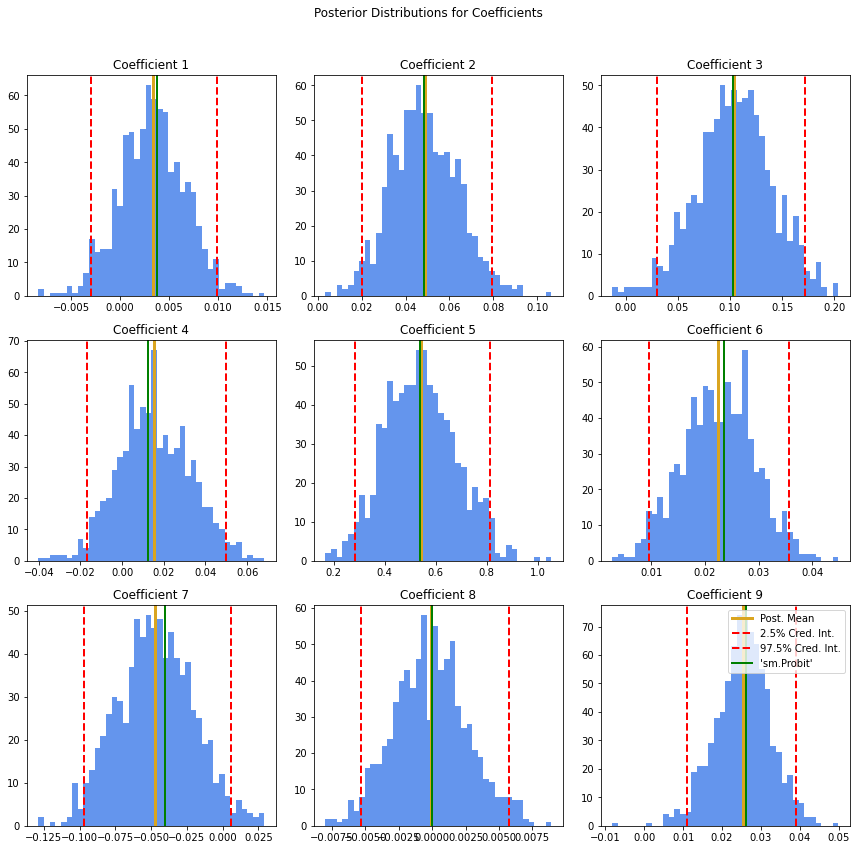

In [91]:
 #Set up the figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Posterior Distributions for Coefficients')

for i in range(3):
    for j in range(3):
        # Calculate mean and credible intervals for each coefficient
        mean_beta = np.mean(beta_chain[:, i * 3 + j + 1])
        cred_int = np.percentile(beta_chain[:, i * 3 + j+1], [2.5, 97.5])

        # Plot histogram for the posterior distribution
        axes[i, j].hist(beta_chain[:, i * 3 + j +1], bins=40, color="cornflowerblue")
        axes[i, j].axvline(x=mean_beta, color="goldenrod", linewidth=3, label="Post. Mean")
        axes[i, j].axvline(x=cred_int[0], color="red", linestyle='--', linewidth=2, label="2.5% Cred. Int.")
        axes[i, j].axvline(x=cred_int[1], color="red", linestyle='--', linewidth=2, label="97.5% Cred. Int.")
        axes[i, j].axvline(x= probit_model.params[i * 3 + j +1], color="green", linewidth=2, label="'sm.Probit'")
        axes[i, j].set_title(f'Coefficient {i * 3 + j + 1}')

axes[2, 2].legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout 
plt.show()

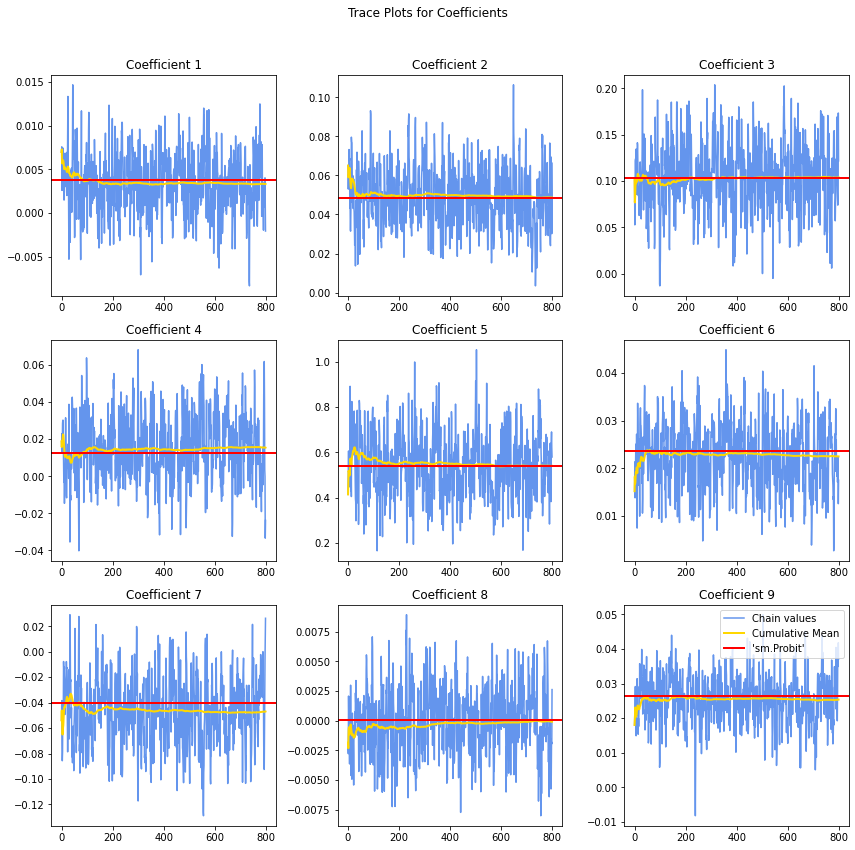

In [96]:
# Set up the figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Trace Plots for Coefficients')

for i in range(3):
    for j in range(3):
        # Plot the trace plot for the chain values
        axes[i, j].plot(beta_chain[:, i * 3 + j +1], color="cornflowerblue", label="Chain values")
        cumulative_mean = np.cumsum(beta_chain[:, i * 3 + j+1]) / np.arange(1, len(beta_chain) + 1)
        axes[i, j].plot(cumulative_mean, color="#FFD700",  linewidth=2, label="Cumulative Mean")
        axes[i, j].axhline(y= probit_model.params[i * 3 + j +1], color="red", linewidth=2, label="'sm.Probit'")
        axes[i, j].set_title(f'Coefficient {i * 3 + j + 1}')

axes[2, 2].legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout 
plt.show()

Also the autocorrelation plot may be useful:

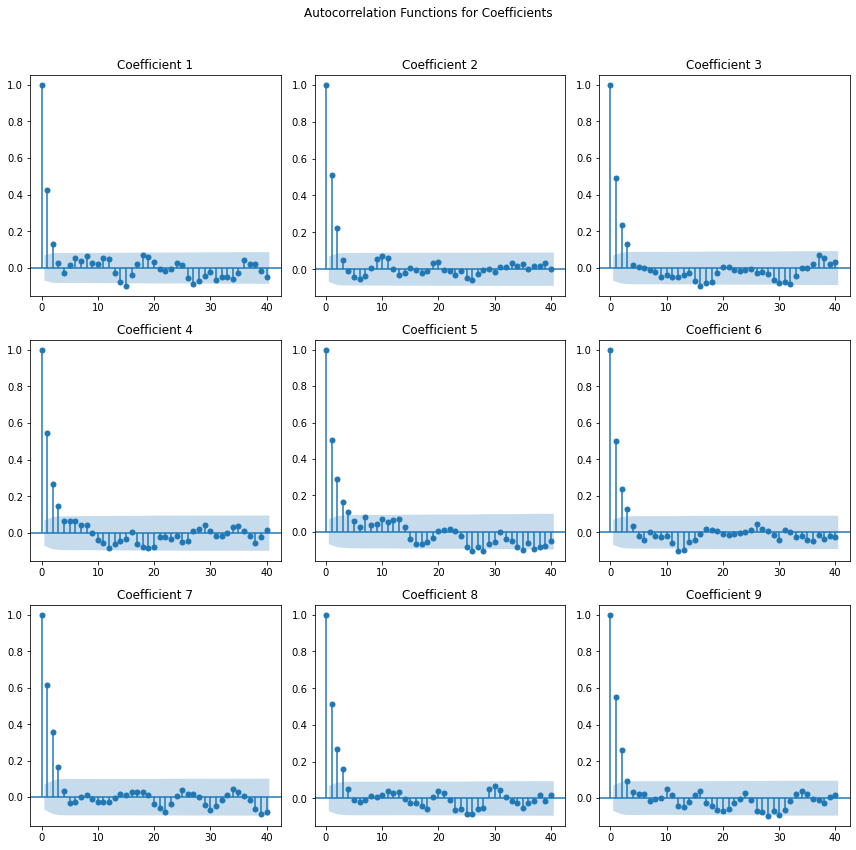

In [98]:
from statsmodels.graphics.tsaplots import plot_acf

# Set up the figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Autocorrelation Functions for Coefficients')

for i in range(3):
    for j in range(3):
        # Plot the autocorrelation function for each coefficient
        plot_acf(beta_chain[:, i * 3 + j+1], ax=axes[i, j], lags=40, title=f'Coefficient {i * 3 + j + 1}')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to prevent title overlap
plt.show()